In [247]:
%%capture
import pandas as pd, pprint, sys, requests, numpy as np, matplotlib.pyplot as plt
import json, re, ast, time
import seaborn as sns
plt.style.use('ggplot')
import os
pd.set_option('display.max_columns', None)

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem import SnowballStemmer
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.probability import FreqDist


from googletrans import Translator
translator = Translator(service_urls=['translate.google.com'])
from wordcloud import WordCloud


In [2]:
path = 'C:/Users/wonch/OneDrive/Escritorio/Projects/Prueba Tecnica DD360/reto2/raw_data/'

In [3]:
places_details = pd.read_csv(path+'places_details.csv')
places_reviews = pd.read_csv(path+'places_reviews.csv')

In [4]:
# check for missing values after treatment
total = places_reviews.isnull().sum().sort_values(ascending=False)
percent = (places_reviews.isnull().sum()/places_reviews.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent of missing'])
missing_data.head(20)

,Total,Percent of missing
url,37836,0.804696
reviewer,37836,0.804696
reviewer_avatar,37836,0.804696
datetime,37836,0.804696
rating,37836,0.804696
text,37836,0.804696
language,37836,0.804696
id,37836,0.804696
place_id,37836,0.804696


#### It seems that the dataset is filled in with empty rows with the same percentage. These} can be safely dropped

In [5]:
places_reviews.dropna(inplace=True)

In [6]:
# check for missing values after treatment
total = places_reviews.isnull().sum().sort_values(ascending=False)
percent = (places_reviews.isnull().sum()/places_reviews.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent of missing'])
missing_data.head(20)

,Total,Percent of missing
url,0,0.0
reviewer,0,0.0
reviewer_avatar,0,0.0
datetime,0,0.0
rating,0,0.0
text,0,0.0
language,0,0.0
id,0,0.0
place_id,0,0.0


In [7]:
places_reviews['language'].value_counts()

language
es         8677
en          431
pt           23
sl           11
fr            6
pl            4
gl            3
id            2
sv            2
ko            2
ar            2
ca            2
ja            2
de            2
zh            2
hi            2
zh-Hant       2
it            2
fi            1
tr            1
ro            1
ru            1
ku            1
cs            1
Name: count, dtype: int64

#### The reviews are predominantely made in spanish, which then means it would be easier to translate the rest to spanish for ease of computation and complexity reduction and then create a method for Natural Language Processing for spanish.
#### Additional text transformation to reduce errors -> remove emojis, replace empty comments with 'neutral' so they are counted as neutral

In [8]:
def translate_text(text):
    translation = translator.translate(text, dest='es')
    return translation.text

In [9]:
def remove_emojis(text):
    # Emoji pattern
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002500-\U00002BEF"  # chinese characters
                               u"\U00002702-\U000027B0"
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               u"\U0001f926-\U0001f937"
                               u"\U00010000-\U0010ffff"
                               u"\u2640-\u2642"
                               u"\u2600-\u2B55"
                               u"\u200d"
                               u"\u23cf"
                               u"\u23e9"
                               u"\u231a"
                               u"\ufe0f"  # dingbats
                               u"\u3030"
                               "]+", flags=re.UNICODE)

    # Remove emojis from the text
    text_without_emojis = emoji_pattern.sub(r'', text)

    return text_without_emojis


In [10]:
def replace_empty_text(text):
    pattern = r'^\W*$'  # Matches text with only non-word characters

    if re.match(pattern, text):
        return "neutral"  # Replace empty text with "neutral" as these comments should be counted as neutral
    else:
        return text

In [11]:
places_reviews.loc[:, 'text'] = places_reviews.copy().loc[:, 'text'].apply(remove_emojis)

In [12]:
places_reviews.loc[:, 'text'] = places_reviews.copy().loc[:, 'text'].apply(replace_empty_text)

In [13]:
df = places_reviews.copy()[places_reviews['language']!='es']
df = df.reset_index(drop=True)

In [58]:
dfcopy = df.copy()

In [59]:
%%time
for i in range(df.shape[0]):
    time.sleep(0.2)
    df.loc[i, 'text'] = translate_text(df.copy().loc[i, 'text'])

CPU times: total: 0 ns
Wall time: 2.93 s


In [74]:
df.loc[:,'language']='es'

In [75]:
df.to_csv(path+'translatedstuff.csv', index=False)

In [76]:
df_es = places_reviews.copy()[places_reviews['language']=='es']

In [84]:
df_translated = pd.concat([df_es,df])
df_translated = df_translated.reset_index(drop=True)

In [92]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('vader_lexicon')

True

In [93]:
def preprocess_text(text):
    # Tokenize the text into sentences and words
    sentences = sent_tokenize(text)
    words = [word.lower() for sentence in sentences for word in word_tokenize(sentence)]

    # Remove stopwords and punctuation
    stop_words = set(stopwords.words('spanish'))
    words = [word for word in words if word.isalpha() and word not in stop_words]

    # Stem the words
    stemmer = SnowballStemmer('spanish')
    words = [stemmer.stem(word) for word in words]

    return words

In [179]:
def calculate_sentiment(text):
    sia = SentimentIntensityAnalyzer()
    sentiment_scores = sia.polarity_scores(text)
    compound_score = sentiment_scores['compound']
    
    if compound_score >= -0.001:
        sentiment = 'positive'
    elif compound_score <= -0.2:
        sentiment = 'negative'
    else:
        sentiment = 'neutral'
    
    return sentiment

In [220]:
def extract_topics(reviews, num_topics):
    # Preprocess the text in each review
    preprocessed_reviews = [preprocess_text(review) for review in reviews]

    # Flatten the preprocessed reviews
    flattened_reviews = [word for review in preprocessed_reviews for word in review]

    # Calculate the frequency distribution of words
    fdist = FreqDist(flattened_reviews)

    # Get the most common words as topics
    topics = fdist.most_common(num_topics)
    
    return topics

In [181]:
%%time
df_translated.loc[:, 'sentiment'] = df_translated.copy().loc[:, 'text'].apply(calculate_sentiment)

CPU times: total: 38.4 s
Wall time: 38.4 s


In [182]:
df_translated['sentiment'].value_counts()

sentiment
positive    8075
negative    1093
neutral       15
Name: count, dtype: int64

In [183]:
%%time
df_translated['topics'] = df_translated['text'].apply(lambda x: extract_topics([x], 5))

CPU times: total: 5.3 s
Wall time: 5.32 s


In [191]:
merged = pd.merge(df_translated, places_details, on=["place_id", "place_id"])

In [194]:
merged['business_status'].value_counts()

business_status
OPERATIONAL           9095
CLOSED_TEMPORARILY      88
Name: count, dtype: int64

In [197]:
merged = merged.copy()[merged['business_status']=='OPERATIONAL'].reset_index(drop=True)

In [199]:
merged.head(1)

,url,reviewer,reviewer_avatar,datetime,rating_x,text,language,id,place_id,sentiment,topics,name,business_status,latitude,longitude,user_ratings_total,rating_y,website,price_level,photos,sunday_open,sunday_close,monday_open,monday_close,tuesday_open,tuesday_close,wednesday_open,wednesday_close,thursday_open,thursday_close,friday_open,friday_close,saturday_open,saturday_close,tipo_lugar
0,https://www.google.com/maps/reviews/data=!4m5!...,Josial Iszsa,https://lh3.googleusercontent.com/a-/AOh14GhZ0...,2020-07-30T00:26:00Z,5.0,"Higiene, medidas de sana distancia, excelente ...",es,17546225955757877359-1596057977.804,ChIJ_6PxIP_-0YURb-iv-Yq3gPM,positive,"[(higien, 1), (med, 1), (san, 1), (distanci, 1...",La Cocina Tradicional Mexicana,OPERATIONAL,19.388755,-99.141413,104,4.5,https://www.facebook.com/La-Cocina-Tradicional...,NaN,"[{'height': 3120, 'html_attributions': ['<a hr...",0,0,800,1700,800,1700,800,1700,800,1700,800,1700,930,1700,Comida mexicana


In [204]:
merged[['id', 'place_id', 'reviewer', 'rating_x', 'text', 
        'sentiment', 'topics', 'name',
       'business_status', 'rating_y','tipo_lugar']]

,id,place_id,reviewer,rating_x,text,sentiment,topics,name,business_status,rating_y,tipo_lugar
0,17546225955757877359-1596057977.804,ChIJ_6PxIP_-0YURb-iv-Yq3gPM,Josial Iszsa,5.0,"Higiene, medidas de sana distancia, excelente ...",positive,"[(higien, 1), (med, 1), (san, 1), (distanci, 1...",La Cocina Tradicional Mexicana,OPERATIONAL,4.5,Comida mexicana
1,17546225955757877359-1594156694.121,ChIJ_6PxIP_-0YURb-iv-Yq3gPM,Osvaldo Caballero,5.0,Buen lugar para comer y pasar el rato,positive,"[(buen, 1), (lug, 1), (com, 1), (pas, 1), (rat...",La Cocina Tradicional Mexicana,OPERATIONAL,4.5,Comida mexicana
2,17546225955757877359-1584593609.046,ChIJ_6PxIP_-0YURb-iv-Yq3gPM,Marbella Miss,5.0,Súper delicioso todo y muy económico,positive,"[(sup, 1), (delici, 1), (econom, 1)]",La Cocina Tradicional Mexicana,OPERATIONAL,4.5,Comida mexicana
3,17546225955757877359-1584048420.225,ChIJ_6PxIP_-0YURb-iv-Yq3gPM,Erick romero casas,4.0,"Muy buen servicio, costos un poco elevados",positive,"[(buen, 1), (servici, 1), (cost, 1), (elev, 1)]",La Cocina Tradicional Mexicana,OPERATIONAL,4.5,Comida mexicana
4,17546225955757877359-1583628551.982,ChIJ_6PxIP_-0YURb-iv-Yq3gPM,Yoscelina Gomez,3.0,"Comida rica, buen precio, atención normal, la ...",positive,"[(com, 2), (ric, 2), (buen, 2), (preci, 2), (a...",La Cocina Tradicional Mexicana,OPERATIONAL,4.5,Comida mexicana
...,...,...,...,...,...,...,...,...,...,...,...
9090,8699349291784817290-1583376743.983,ChIJRU2FLk__0YURikrh-RZMung,Denisse Silva,3.0,"Meseros siempre con mala cara, tortas ahogadas...",positive,"[(meser, 1), (siempr, 1), (mal, 1), (car, 1), ...",El Pialadero de Guadalajara,OPERATIONAL,4.3,Comida mexicana
9091,8699349291784817290-1583205140.202,ChIJRU2FLk__0YURikrh-RZMung,Aanthony Lgn,5.0,Muy ricas las tortas ahogadas,positive,"[(ric, 1), (tort, 1), (ahog, 1)]",El Pialadero de Guadalajara,OPERATIONAL,4.3,Comida mexicana
9092,8699349291784817290-1583204677.566,ChIJRU2FLk__0YURikrh-RZMung,Javier Morales,5.0,Riquísimo\nTortas ahogadas\nTacos dorados\nTac...,positive,"[(tac, 2), (riquisim, 1), (tort, 1), (ahog, 1)...",El Pialadero de Guadalajara,OPERATIONAL,4.3,Comida mexicana
9093,8699349291784817290-1583197182.965,ChIJRU2FLk__0YURikrh-RZMung,Alejandro Chavez,4.0,Porque la perfección no existe le doy 4 estrel...,negative,"[(delici, 2), (perfeccion, 1), (exist, 1), (do...",El Pialadero de Guadalajara,OPERATIONAL,4.3,Comida mexicana


In [236]:
merged['place_id'].value_counts()

place_id
ChIJ7w5HFPj_0YURHTyE1LwPB_c    327
ChIJPVNOCAAC0oURSYtY8JP39VE    198
ChIJ7WAfwbv_0YURiSIZGMdRuto    115
ChIJv5KO8Uz-0YURvTUyYxZs3pw    113
ChIJBeL1vQj_0YURMcKqVViw2ok    113
                              ... 
ChIJObz6-D0FzoUR3DltyAAnV4w     21
ChIJs7qYCksA0oURhrtRb-GnQW8     18
ChIJPTKIjkL_0YURxVHr3fClJVs     12
ChIJsfag4kgA0oURO5aVp6M1iM4     11
ChIJkzWrrxX5zYURjohBBW22J98      5
Name: count, Length: 112, dtype: int64

In [243]:
%%time

comments = merged['text'].tolist()

preprocessed_comments = [preprocess_text(comment) for comment in comments]

flattened_comments = [word for comment in preprocessed_comments for word in comment]

fdist = FreqDist(flattened_comments)

num_topics = 50

topics = fdist.most_common(num_topics)
main_topics = [topic[0] for topic in topics]

CPU times: total: 5.19 s
Wall time: 5.16 s


In [244]:
fdist

FreqDist({'buen': 3371, 'com': 2868, 'excelent': 2342, 'lug': 2162, 'servici': 1627, 'ric': 1544, 'delici': 1239, 'atencion': 1193, 'preci': 982, 'sabor': 887, ...})

In [246]:
main_topics

['buen',
 'com',
 'excelent',
 'lug',
 'servici',
 'ric',
 'delici',
 'atencion',
 'preci',
 'sabor',
 'mejor',
 'bien',
 'recomend',
 'platill',
 'si',
 'sup',
 'calid',
 'agrad',
 'tac',
 'ambient',
 'siempr',
 'restaur',
 'gust',
 'recom',
 'mexican',
 'sol',
 'pued',
 'aliment',
 'menu',
 'amabl',
 'gran',
 'birri',
 'car',
 'prob',
 'personal',
 'varied',
 'experient',
 'carn',
 'sazon',
 'hac',
 'encant',
 'val',
 'limpi',
 'pequeñ',
 'mal',
 'esper',
 'bonit',
 'opcion',
 'meser',
 'sals']

In [242]:
['bueno',
 'comida',
 'excelente',
 'lugar',
 'servicio',
 'rico',
 'deliciso',
 'atencion',
 'precio',
 'sabor',
 'recomendad',
 'platillo',
 'superior',
 'calidad',
 'agradable',
 'tacto',
 'ambiente',
 'siempre',
 'restaurte',
 'gusto',
 'recomdable',
 'mexicano',
 'alimentos',
 'menu',
 'amable']

['bueno',
 'comida',
 'excelente',
 'lugar',
 'servicio',
 'rico',
 'deliciso',
 'atencion',
 'precio',
 'sabor',
 'recomendad',
 'platillo',
 'superior',
 'calidad',
 'agradable',
 'tacto',
 'ambiente',
 'siempre',
 'restaurte',
 'gusto',
 'recomdable',
 'mexicano',
 'alimentos',
 'menu',
 'amable']

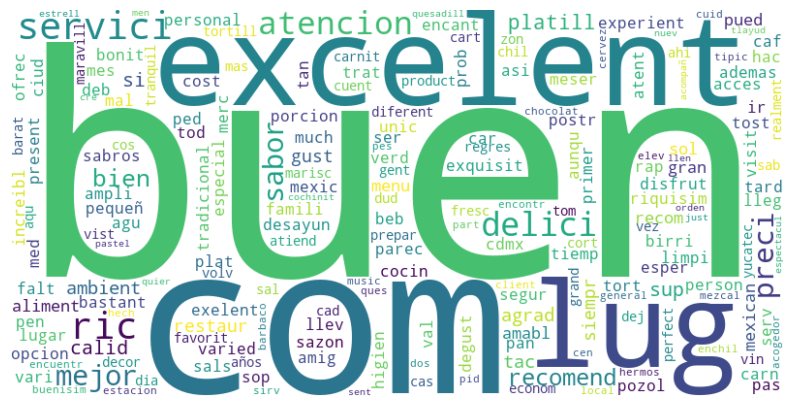

In [249]:
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(fdist)
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()